# YOUR PROJECT TITLE

Imports and set magics:

In [1]:
import numpy as np
from scipy import optimize
import sympy as sm
from sympy.solvers import solve
# for later use, in order to write tilde-variables, we need the following package
from sympy import *
sm.init_printing()
import matplotlib.pyplot as plt
from IPython.display import display, Math, Markdown

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject

# **Model description**

**The Solow model with human capital** 

The extended Solow model contains the following variables:
1. $K_t$ is physical capital
2. $H_t$ is human capital
3. $A_t$ is technology
4. $L_t$ is labour

The production function
$$
Y_t = K_t^{\alpha}H_t^{\varphi}(A_tL_t)^{1-\alpha-\varphi}, \quad 0<\alpha<1, 0<\varphi<1, \alpha+\varphi<1
$$

The household decides how much to save of physical capital and of human capital as a constant fraction of income.
$$
S_t = (s_K + s_H)Y_t, \quad s_K+s_H<1
$$

$s_K$ denotes the savings rate of physical capital and $s_H$ denotes the savings of human capital.

This lead to the accumulation of phycial capital
$$
K_{t+1}=s_KY_t+(1-\delta)K_t, \quad K_0 \, \text{given}
$$

As well as the accumulation of human capital
$$
H_{t+1}=s_HY_t+(1-\delta)H_t, \quad H_0 \, \text{given}
$$

Furthermore the accumulation of technology and labour is defined as follows:
$$
A_{t+1} = (1+g)A_t, \quad A_0 \, \text{given}
$$
$$
L_{t+1} = (1+n)L_t, \quad L_0 \, \text{given}
$$
Where  $g$ is a constant rate of technological progress, and $n$ is the population growth.

We define the following tilde-variables, which is the technology adjusted variables.
$$
\tilde{y}_{t}= \frac{Y_t}{A_tL_t}
$$
$$
\tilde{k}_{t}= \frac{K_t}{A_tL_t}
$$
$$
\tilde{h}_{t}= \frac{H_t}{A_tL_t}
$$

The **production function** has **constant returns to scale** meaning that
$$
\frac{Y_t}{A_tL_t} = \frac{K_t^{\alpha}H_t^{\varphi}(A_tL_t)^{1-\alpha-\varphi}}{A_tL_t}=\tilde{k}_{t}^{\alpha}\tilde{h}_{t}^{\varphi}
$$

We are then left with two transistion equations. One equation for physical capital and one equation for human capital.
$$
\tilde{k}_{t+1} = \frac{1}{(1+n)(1+g)}(s_K\tilde{k}_{t}^{\alpha}\tilde{h}_{t}^{\varphi}+(1+{\delta})\tilde{k}_{t})
$$
$$
\tilde{h}_{t+1} = \frac{1}{(1+n)(1+g)}(s_H\tilde{k}_{t}^{\alpha}\tilde{h}_{t}^{\varphi}+(1+{\delta})\tilde{h}_{t})
$$

By subtracting $\tilde{k}_{t}$ and $\tilde{h}_{t}$ and assuming that $\tilde{k}_{t+1} = \tilde{k}_{t} =\tilde{k}^{*}$ and $\tilde{h}_{t+1} = \tilde{h}_{t} =\tilde{h}^{*}$ we are left with the following Solow equations.

$$
0 = \frac{1}{(1+n)(1+g)}(s_K(\tilde{k}^{*})^{\alpha}(\tilde{h}^{*})^{\varphi}-(n+g+{\delta}+ng)\tilde{k}^{*})
$$
$$
0 = \frac{1}{(1+n)(1+g)}(s_H(\tilde{k}^{*})^{\alpha}(\tilde{h}^{*})^{\varphi}-(n+g+{\delta}+ng)\tilde{h}^{*})
$$

## **Analytical solution**

Given the nature of our model, sympy cannot solve our system of nonlinear equations analytically. If we had a simpler system, we would have solved it as below. When we run the following code we get a "NotImplementedError", which is why we have chosen to look past an analyical solution.

In [94]:
# defining all variables
ktilde = sm.symbols('ktilde')
htilde = sm.symbols('htilde')
sK = sm.symbols('s_K')
sH = sm.symbols('s_H')
delta = sm.symbols('delta')
g = sm.symbols('g')
n = sm.symbols('n')
alpha = sm.symbols('alpha')
varphi = sm.symbols('varphi')

# define the solow equations
#solowK = sm.Eq(0, (1/((1+n)*(1+g)))*(sK*ktilde**alpha*htilde**varphi-(n+g+delta+n*g)*ktilde))
#solowH = sm.Eq(0, (1/((1+n)*(1+g)))*(sH*ktilde**alpha*htilde**varphi-(n+g+delta+n*g)*htilde))

#solve the equation system of 2 equations with 2 unnowns
#ss = sm.solve([solowK, solowH], [ktilde, htilde])[0]
#ss


## **Numerical solution**

**Algorithm:**
1. Define model parameters: savings rate in physical capital (*sK*), savings rate in human capital (*sH*), depreciation rate (*delta*), technological growth rate (*g*), population growth rate (*n*), return on physical capital (*alpha*) and return on human capital (*varphi*).
2. Define the steady-state expressions for physical capital, k_star, and human capital, h_star, as functions of the inputs ktilde and htilde.
3. Define the objective function, as a function that returns a list of the values of k_star and h_star evaluated at the input values ktilde and htilde.
4. Define an initial guess for the values of ktilde and htilde, x0.
5. Call the scipy.optimize.root function, passing the objective function, initial guess, and the method="krylov" argument. Assign the output to a variable.
6. Check the convergence of the solver by checking the value of the success field in the output variable, solution. **If success is True, the solver has converged; otherwise, it has not.**
7. **Extract the values of ktilde and htilde from the x field of the solution variable.**
8. **Return the values of ktilde and htilde as the solution to the model.**

Based on "Introducing Advanced Macroeconomics" by Whitta-Jacobsen and Sørensen (2010) we find plausible values for our parameters. 
We assume a total savings rate of 20%, aligned with theory, and therefore assume a savings rate of 10% for respectively physical and human capital. We also have $\delta$ + $g$ should be 0,75, hence the values for the parameters are $\delta$ = 5% and $g$ = 2,5%. The population is assumed to increase with 1%. $\alpha$ and $\varphi$ is as usual assumed to be $\frac{1}{3}$ each.


In [36]:
# set baseline parameters
sK = 0.1
sH = 0.11
delta = 0.05
g = 0.025
n = 0.01
alpha = 1/3
varphi = 1/3

In [2]:
# global vars for data collection
evals = 0
fks = [] # function values for k's
fhs = [] # function values for h's

# using this collect function as the callback function for the Newton-Krylov root solver
# where x is the current solution and f the corresponding residual
# Hhwever, we don't care for the x's only the function values
def krylov_collect(x, fs):
    global evals
    global fks
    global fhs
    fks.append(abs(fs[0])) # we take the absolute value of the func value bc the difference matter, not the sign
    fhs.append(abs(fs[1]))
    evals += 1

# x0 is our initial values
def reset(x0, objective):
    global evals
    global fks
    global fhs
    evals = 0
    
    # the callback method doesn't return the functional values for our inital values
    # we initialize them in our data collection arrays here
    init_fs = objective(x0)
    fks = [abs(init_fs[0])]
    fhs = [abs(init_fs[1])]

def plot_convergence():
    global evals
    global fks
    global fhs

    fig = plt.figure(figsize=(10,4))

    # plot the function values for the k's
    ax = fig.add_subplot(1,2,1)
    ax.plot(np.arange(evals+1),fks,'-o',ms=4,color='black')
    ax.set_title("k convergence")
    ax.set_xlabel('iteration')
    ax.set_ylabel('function value')

    # pot the function values for the h's
    ax = fig.add_subplot(1,2,2)
    ax.plot(np.arange(evals+1),fhs,'-o',ms=4,color='black')
    ax.set_title("h convergence")
    ax.set_xlabel('iteration')
    ax.set_ylabel('function value')

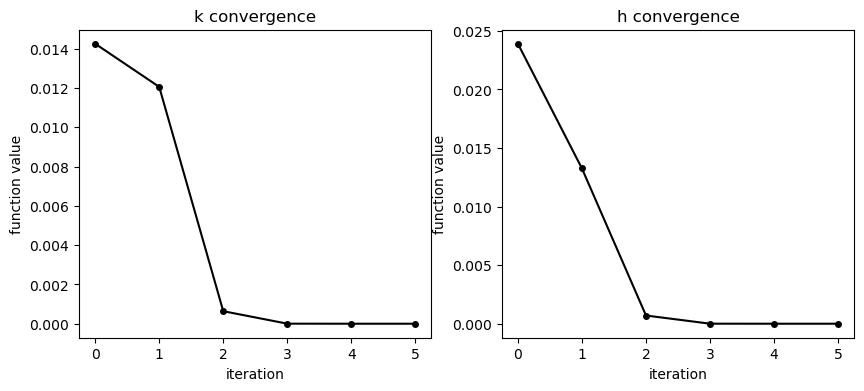

In [47]:
def steady_state(sK, sH, delta, g, n, alpha, varphi):
    """ root finding function

    Args:
        ktilde (float): physical capital per effective worker
        htilde (float): human capital per effective worker
        sK (float): savings rate in physical capital
        sH (float): savings rate in human capital
        delta (float): depreciation rate
        g (float): technological growth rate
        n (float): population growth
        alpha (float): return of physical capital
        varphi (float): return of human capital

    Returns:

    """

    # define Solow equations for physical and human capital - both expressions depend on ktilde and htilde
    def solow_k(ktilde, htilde): return ((1/((1+n)*(1+g))) *
                                        (sK*ktilde**alpha*htilde**varphi-(n+g+delta+n*g)*ktilde))
    def solow_h(ktilde, htilde): return ((1/((1+n)*(1+g))) *
                                        (sH*ktilde**alpha*htilde**varphi-(n+g+delta+n*g)*htilde))

    # initial guess
    x0 = [1, 1]
        
    # join solow_k and solow_h as a non-linear system to find roots
    def objective(x): return [solow_k(x[0], x[1]), solow_h(x[0], x[1])]

    # Reset our global data collection vars
    reset(x0, objective)

    # options for the Newton-Krylov solver
    options={
        'disp':False, # set to True for debugging iteration steps
        "ftol":1e-14  # determine the relative tolerance for the residual
        }
    # solving for roots
    solution = optimize.root(objective, x0, method="krylov", callback=krylov_collect, options=options) # using the Newton-Krylov solver - can deal with large non-linear problems

    # plot the convergences for k and h
    plot_convergence()

    ss_k = solution.x[0]
    ss_h = solution.x[1]
 
    return ss_k, ss_h

# save valyes of ss_k and ss_h
ss_k, ss_h = steady_state(sK, sH, delta, g, n, alpha, varphi)


Now we have the steady state values of physical and human capital. We can now compute the steady state value of GDP per effective worker:
$$
\tilde{y}^{*} = (\tilde{k}^{*})^{\alpha}(\tilde{h}^{*})^{\varphi}
$$

In [97]:
def y_steady_state(ss_k, ss_h, alpha, varphi):
    """ calculate GDP per effective worker in steady state

    Args:
        ss_k (float): steady state value of physical capital per effective worker
        ss_h (float): steady state value of human capital per effective worker
        alpha (float): return of physical capital
        varphi (float): return of human capital

    Returns:
        ss_y (float): steady state value of GDP per effective worker

    """
    # define steady state value for y
    ss_y = ss_k**alpha*ss_h**varphi

    return ss_y

# save value of ss_y
ss_y = y_steady_state(ss_k, ss_h, alpha, varphi)


The numerical solutions for the Solow model with human capital with the parameters defined above is then:

In [98]:
print(f'Numerical solution for k* = {ss_k:.3f}')
print(f'Numerical solution for h* = {ss_h:.3f}')
print(f'Numerical solution for y* = {ss_y:.3f}')

Numerical solution for k* = 1.614
Numerical solution for h* = 1.614
Numerical solution for y* = 1.376


# **Further analysis**

We can analyse the model using a phase diagram. Here we can show the transition to steady state. For this purpose, we need to solve for the null clines. This is done with the Solow equations where we subtract $\tilde{k}_{t}$ from $\tilde{k}_{t+1}$ and thereby obtain an expression for $\Delta \tilde{k}_{t}$. The same is done for human capital where we subtract $\tilde{h}_{t}$ from $\tilde{h}_{t+1}$ and thereby obtain an expression for $\Delta \tilde{h}_{t}$. To obtain the null clines we set the change equal to 0 and solve for $\tilde{h}_{t}$ as a function of $\tilde{k}_{t}$ using Sympy.

In [99]:
def null_clines():
    # defining all variables
    ktilde = sm.symbols('ktilde')
    htilde = sm.symbols('htilde')
    sK = sm.symbols('s_K')
    sH = sm.symbols('s_H')
    delta = sm.symbols('delta')
    g = sm.symbols('g')
    n = sm.symbols('n')
    alpha = sm.symbols('alpha')
    varphi = sm.symbols('varphi')
    # define solow equations and set them equal to 0
    dktilde = sm.Eq(0, (1/((1+n)*(1+g)))*(sK*ktilde**alpha * htilde**varphi-(n+g+delta+n*g)*ktilde))
    dhtilde = sm.Eq(0, (1/((1+n)*(1+g)))*(sH*ktilde**alpha * htilde**varphi-(n+g+delta+n*g)*htilde))
    # solve for htilde (=null clines)
    null_dktilde = sm.solve(dktilde, htilde)
    null_dhtilde = sm.solve(dhtilde, htilde)
    # check null clines
    null_dktilde = null_dktilde # only one solution to null
    null_dhtilde = null_dhtilde

    return null_dktilde, null_dhtilde

# print nullclines
print(f'htilde = {null_clines()[0]}, d_ktilde = 0')
print(f'htilde = {null_clines()[1]}, d_htilde = 0')


htilde = [(ktilde**(1 - alpha)*(delta + g*n + g + n)/s_K)**(1/varphi)], d_ktilde = 0
htilde = [((delta + g*n + g + n)/(ktilde**alpha*s_H))**(1/(varphi - 1))], d_htilde = 0


Define nullclines as functions:

In [100]:
def null_k(ktilde, alpha, varphi, delta, g, n, sK):
    return (ktilde**(1 - alpha)*(delta + g*n + g + n)/sK)**(1/varphi)

def null_h(ktilde, alpha, varphi, delta, g, n, sH):
    return ((delta + g*n + g + n)/(ktilde**alpha*sH))**(1/(varphi - 1))

/var/folders/02/k6_n1tbx3dx3n9lwnsrf_5qr0000gp/T/ipykernel_7341/1657026960.py:5: RuntimeWarning: divide by zero encountered in true_divide
  return ((delta + g*n + g + n)/(ktilde**alpha*sH))**(1/(varphi - 1))
/var/folders/02/k6_n1tbx3dx3n9lwnsrf_5qr0000gp/T/ipykernel_7341/3405136020.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
/var/folders/02/k6_n1tbx3dx3n9lwnsrf_5qr0000gp/T/ipykernel_7341/3405136020.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


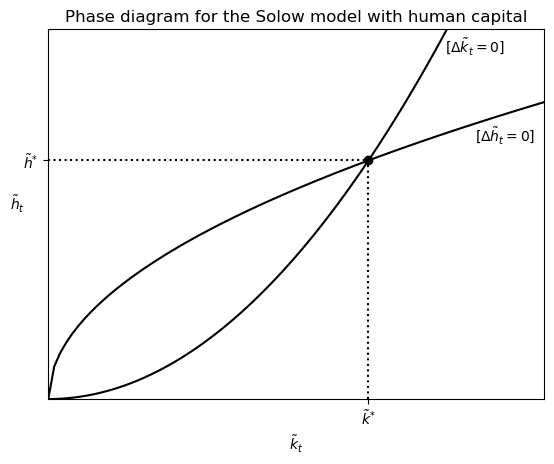

In [101]:
# create figure
fig = plt.figure()
# create plot
ax = fig.add_subplot(1, 1, 1)
# create grid
k_range = np.linspace(0, 3, 100)
h_range = np.linspace(0, 3, 100)
k_grid, h_grid = np.meshgrid(k_range, h_range)

# define range for ktilde
ktilde = np.linspace(0, 3, 100)

# plot null_k and null_h
ax.plot(ktilde, null_k(ktilde, alpha, varphi, delta, g, n, sK), color='black')
ax.plot(ktilde, null_h(ktilde, alpha, varphi, delta, g, n, sH), color='black')
# alterations to figure
plt.xlim(0, 2.5)
plt.ylim(0, 2.5)
ax.set_xlabel(r'$\tilde{k}_{t}$')
ax.set_ylabel(r'$\tilde{h}_{t}$', rotation=0)
ax.set_title("Phase diagram for the Solow model with human capital")
plt.text(2.0, 2.35, r'[$\Delta \tilde{k}_{t}=0$]')
plt.text(2.15, 1.75, r'[$\Delta \tilde{h}_{t}=0$]')
# insert steady state
plt.scatter(ss_k, ss_h, color='black')
# set x tick
xtick_loc = [ss_k]
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = r'$\tilde{k}^{*}$'
ax.set_xticklabels(labels)
# set y tick
ytick_loc = [ss_h]
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[0] = r'$\tilde{h}^{*}$'
ax.set_yticklabels(labels)
# remove ticks
ax.set_xticks(xtick_loc)
ax.set_yticks(ytick_loc)
# insert dotted lines from axes to steady state
plt.axvline(ss_k, ymax=ss_h/2.5, linestyle='dotted', color='black')
plt.axhline(ss_h, xmax=ss_k/2.5, linestyle='dotted', color='black')

We get a "RuntimeWarning: divide by zero encountered in true_divide".  This does not apply for our model, since we define $\varphi<1$.

The graph shows the transition to steady state. The steady state is where the null clines intersect each other, marked with a dot.

### **Increase in $\bold{s_H}$**

To analyse the change in the phase diagram, we increase the savings rate in human capital with 10% (corresponding to an increase in $s_H$ with 0.01 percentage points).

First, we find out what this means for our steady state variables:

In [102]:
# define new steady state
ss_k2, ss_h2 = steady_state(sK, 0.11, delta, g, n, alpha, varphi)

/var/folders/02/k6_n1tbx3dx3n9lwnsrf_5qr0000gp/T/ipykernel_7341/1657026960.py:5: RuntimeWarning: divide by zero encountered in true_divide
  return ((delta + g*n + g + n)/(ktilde**alpha*sH))**(1/(varphi - 1))
/var/folders/02/k6_n1tbx3dx3n9lwnsrf_5qr0000gp/T/ipykernel_7341/1748706629.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
/var/folders/02/k6_n1tbx3dx3n9lwnsrf_5qr0000gp/T/ipykernel_7341/1748706629.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


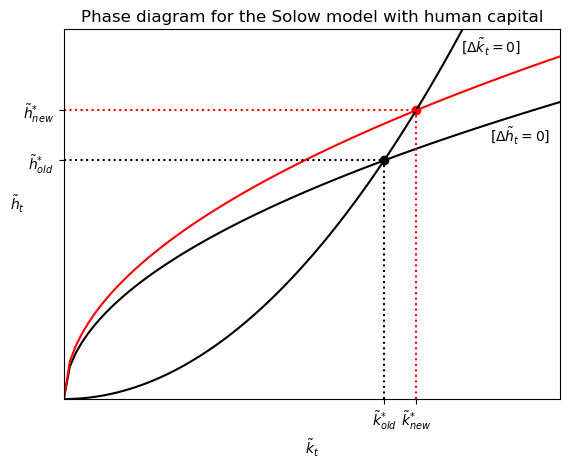

In [103]:
# create figure
fig = plt.figure()
# create plot
ax = fig.add_subplot(1, 1, 1)
# create grid
k_range = np.linspace(0, 3, 100)
h_range = np.linspace(0, 3, 100)
k_grid, h_grid = np.meshgrid(k_range, h_range)

# define range for ktilde
ktilde = np.linspace(0, 3, 100)

# plot null_k and null_h
ax.plot(ktilde, null_k(ktilde, alpha, varphi, delta, g, n, sK), color='black')
ax.plot(ktilde, null_h(ktilde, alpha, varphi, delta, g, n, sH), color='black')
ax.plot(ktilde, null_h(ktilde, alpha, varphi, delta, g, n, 0.11), color='red') # increase in sH
# alterations to figure
plt.xlim(0, 2.5)
plt.ylim(0, 2.5)
ax.set_xlabel(r'$\tilde{k}_{t}$')
ax.set_ylabel(r'$\tilde{h}_{t}$', rotation=0)
ax.set_title("Phase diagram for the Solow model with human capital")
plt.text(2.0, 2.35, r'[$\Delta \tilde{k}_{t}=0$]')
plt.text(2.15, 1.75, r'[$\Delta \tilde{h}_{t}=0$]')
# insert steady state
plt.scatter(ss_k, ss_h, color='black') # old steady state
plt.scatter(ss_k2, ss_h2, color='red') # add new steady state
# set x tick
xtick_loc = [ss_k,ss_k2]
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = r'$\tilde{k}_{old}^{*}$' # old steady state value for ktilde
labels[1] = r'$\tilde{k}_{new}^{*}$' # new steady state value for ktilde
ax.set_xticklabels(labels)
# set y tick
ytick_loc = [ss_h,ss_h2]
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[0] = r'$\tilde{h}_{old}^{*}$' # old steady state value for htilde
labels[1] = r'$\tilde{h}_{new}^{*}$' # new steady state value for htilde
ax.set_yticklabels(labels)
# remove ticks
ax.set_xticks(xtick_loc)
ax.set_yticks(ytick_loc)
# insert dotted lines from axes to steady state
plt.axvline(ss_k, ymax=ss_h/2.5, linestyle='dotted', color='black') # old steady state
plt.axhline(ss_h, xmax=ss_k/2.5, linestyle='dotted', color='black') # old steady state
plt.axvline(ss_k2, ymax=ss_h2/2.5, linestyle='dotted', color='red') # new steady state
plt.axhline(ss_h2, xmax=ss_k2/2.5, linestyle='dotted', color='red') # new steady state

**Intution for increase in $\bold{s_H}$:**
1. The initial shock to $s_H$ increases the savings in human capital, $\tilde{h}_{1}\uparrow$.
2. Production per effective worker increases, $\tilde{h}_{1}\uparrow \Rightarrow \tilde{y}_{1}\uparrow$. This leads to higher savings in both human and physical capital.
3. The effect in step 2 is further increased until transition to the new steady state has finished. 

# **Extension of the model**

We extend the model by using a more general CES function as the production function instead of a Cobb-Douglas function which is a special case of the CES function. The production function is now defined as:
$$
Y_t = \Bigr[\alpha K_{t}^{\frac{\sigma-1}{\sigma}}+\varphi H_{t}^{\frac{\sigma-1}{\sigma}}+(1-\alpha-\varphi)(AL_t)^{\frac{\sigma-1}{\sigma}}\Bigl]^{\frac{\sigma}{\sigma-1}}
$$
where $\sigma$ is the elasticity of substitution for physical capital and human capital. 
When $\sigma\rightarrow1$ we have the special case of a Cobb Douglas function as previously.

Following the same procedures as above, by dividing by ${A}_{t}{L}_{t}$, the output per effective worker becomes:

$$
\hat{y}_{t} =\bigl[\alpha \hat{k}_{t}^{\beta} + \varphi \hat{h}_{t}^{\beta} + (1-\alpha-\varphi)\bigr]^{\frac{1}{\beta}}
$$

Where $\beta$ is equal to $\frac{\sigma-1}{\sigma}$. We have the same the accumulation for physical and human capital as before. Inserting the new expresion for y we obtain the following transition equations.

$$
\hat{k}_{t+1} = \frac{1}{(1+n)(1+g)}(s_K((\alpha \hat{k}_{t}^{\beta}+ \varphi \hat{h}_{t}^{\beta}+(1-\alpha-\varphi))^{\frac{1}{\beta}})+(1+{\delta})\hat{k}_{t})
$$
$$
\hat{h}_{t+1} = \frac{1}{(1+n)(1+g)}(s_H((\alpha \hat{k}_{t}^{\beta}+ \varphi \hat{h}_{t}^{\beta}+(1-\alpha-\varphi)(^{\frac{1}{\beta}})+(1+{\delta})\hat{h}_{t})
$$

By subtracting $\hat{k}_{t}$ and $\hat{h}_{t}$ and assuming that $\hat{k}_{t+1} = \hat{k}_{t} =\hat{k}^{*}$ and $\hat{h}_{t+1} = \hat{h}_{t} =\hat{h}^{*}$ we are left with the following Solow equations.

$$
0 = \frac{1}{(1+n)(1+g)}(s_K((\alpha \hat{k}_{t}^{\beta}+ \varphi \hat{h}_{t}^{\beta}+(1-\alpha-\varphi))^{\frac{1}{\beta}})-(n+g+{\delta}+ng)\hat{k}_{t})
$$
$$
0 = \frac{1}{(1+n)(1+g)}(s_H((\alpha \hat{k}_{t}^{\beta}+ \varphi \hat{h}_{t}^{\beta}+(1-\alpha-\varphi))^{\frac{1}{\beta}})-(n+g+{\delta}+ng)\hat{h}_{t})
$$

The theoretical solution to the problem is 

$$
\hat{k}^{*} = \Biggl[\frac{1-\alpha-\varphi}{(\frac{n+g+\delta}{s_K})^{\frac{\sigma-1}{\sigma}}-\varphi(\frac{s_H}{s_K})^{\frac{\sigma-1}{\sigma}}-\alpha}\Biggr]^{\frac{\sigma}{\sigma-1}}
$$
and
$$
\hat{h}^{*} = \Biggl[\frac{1-\alpha-\varphi}{(\frac{n+g+\delta}{s_H})^{\frac{\sigma-1}{\sigma}}-\alpha(\frac{s_K}{s_H})^{\frac{\sigma-1}{\sigma}}-\varphi}\Biggr]^{\frac{\sigma}{\sigma-1}}
$$

In the end, we will check that the numerical solution is aligned with the theoretical solution. 

We will examine how the steady state depends on different values of $\beta$ and plot this. 

In [153]:
# we define a beta vector
betas = np.linspace(-0.75,0.75,25)

def steady_state_CES(sK, sH, delta, g, n, alpha, varphi, beta):
    """ root finding function

    Args:
        ktilde (float): physical capital per effective worker
        htilde (float): human capital per effective worker
        sK (float): savings rate in physical capital
        sH (float): savings rate in human capital
        delta (float): depreciation rate
        g (float): technological growth rate
        n (float): population growth
        alpha (float): return of physical capital
        varphi (float): return of human capital

    Returns:

    """
    # define empty vectors with the length of betas
    ss_k_CES = np.zeros(len(betas))
    ss_h_CES = np.zeros(len(betas))

    # loop over all value of betas
    for i, beta in enumerate(betas):
        # define Solow equations for physical and human capital - both expressions depend on ktilde and htilde   
        def solow_k(khat, hhat): 
            if beta == 0:
                return ((1/((1+n)*(1+g)))*(sK*(khat**alpha*hhat**varphi)-(n+g+delta+n*g)*khat)) #limit for beta -> 0
            else:
                return ((1/((1+n)*(1+g)))*(sK*((alpha*khat**beta+varphi*hhat**beta+(1-alpha-varphi))**(1/beta))-(n+g+delta+n*g)*khat))
        def solow_h(khat, hhat): 
            if beta == 0:
                return ((1/((1+n)*(1+g)))*(sH*(khat**alpha*hhat**varphi)-(n+g+delta+n*g)*hhat)) #limit for beta -> 0
            else:
                return ((1/((1+n)*(1+g)))*(sH*((alpha*khat**beta+varphi*hhat**beta+(1-alpha-varphi))**(1/beta))-(n+g+delta+n*g)*hhat))

        # initial guess
        x0 = [1, 1]
        
        
        # join solow_k and solow_h as a non-linear system to find roots
        def objective(x): return [solow_k(x[0], x[1]), solow_h(x[0], x[1])]

        # solving for roots
        solution = optimize.root(objective, x0, method="krylov") # using the Newton-Krylov solver - can deal with large non-linear problems
        
        # save steady state values for each value of betas
        ss_k_CES[i] = solution.x[0]
        ss_h_CES[i] = solution.x[1]

    return ss_k_CES, ss_h_CES

# save valyes of ss_k, ss_h
ss_k_CES, ss_h_CES = steady_state_CES(sK, sH, delta, g, n, alpha, varphi, beta)


Text(0.5, 1.0, 'Steady state $\\hat{k}*$, $\\hat{h}*$ for different values of $\\beta$')

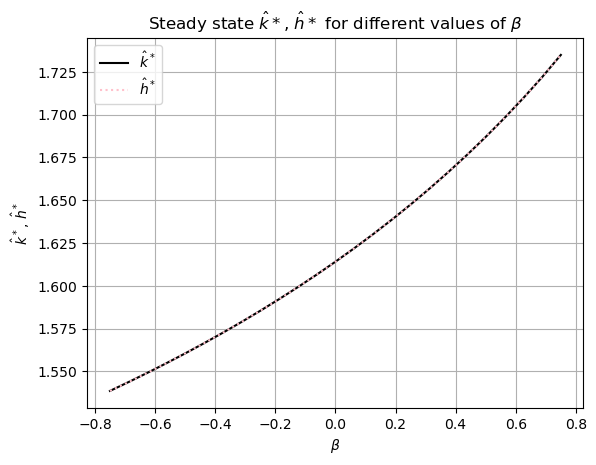

In [154]:
# plot steady state values for k and h for different values of beta
plt.plot(betas, ss_k_CES, color='black', label=r'$\hat{k}^*$')
plt.plot(betas, ss_h_CES, color='pink', linestyle='dotted', label=r'$\hat{h}^*$')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\hat{k}^*$, $\hat{h}^*$')
plt.grid(True)
plt.legend()
plt.title(r'Steady state $\hat{k}*$, $\hat{h}*$ for different values of $\beta$')

We see that $\hat{k}*$ and $\hat{h}*$ are equal for all values of $\beta$ this in not always the case. The steady state values are dependent on the values for the parameters. 

We now compute the theoretical values of the steady state for different values of beta.

In [155]:
# compute theoretical values of steady state
def theoretical_ss_CES(sK, sH, delta, g, n, alpha, varphi, beta):
    if beta == 0:
        k_star = ((sK**(1-varphi)*sH**varphi)/(n+g+delta+n*g))**(1/(1-alpha-varphi))
        h_star = ((sK**alpha*sH**(1-alpha))/(n+g+delta+n*g))**(1/(1-alpha-varphi))
    else:
        k_star = ((1-alpha-varphi)/(((n+g+delta+n*g)/sK)**beta-varphi*(sH/sK)**beta-alpha))**(1/beta)
        h_star = ((1-alpha-varphi)/(((n+g+delta+n*g)/sH)**beta-alpha*(sK/sH)**beta-varphi))**(1/beta)
    return k_star, h_star

k_star_theoretical = np.zeros(len(betas))
h_star_theoretical = np.zeros(len(betas))

for i, beta in enumerate(betas):
    k_star, h_star = theoretical_ss_CES(sK, sH, delta, g, n, alpha, varphi, beta)
    k_star_theoretical[i] = k_star
    h_star_theoretical[i] = h_star

Plot numerical and theoretical values of steady state for different values of beta.

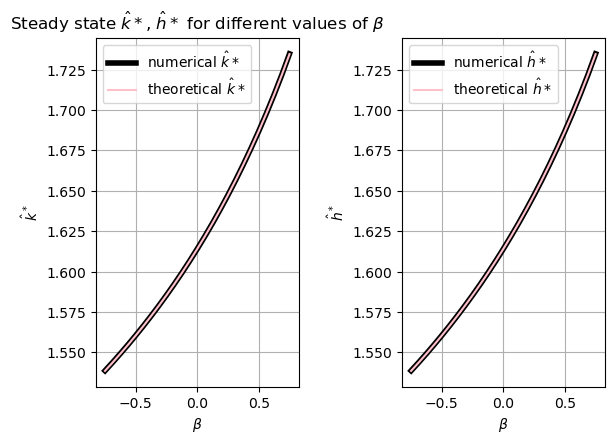

In [152]:
# create figure
fig = plt.figure()
# create plot
ax = fig.add_subplot(1, 2, 1)
plt.plot(betas, ss_k_CES, color='black',label= 'numerical $\hat{k}*$', lw='4')
plt.plot(betas, k_star_theoretical, color='pink', label= 'theoretical $\hat{k}*$')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\hat{k}^*$')
plt.legend()
plt.grid(True)
plt.title(r'Steady state $\hat{k}*$, $\hat{h}*$ for different values of $\beta$');

ax = fig.add_subplot(1, 2, 2)
plt.plot(betas, ss_h_CES, color='black',label= 'numerical $\hat{h}*$', lw='4', ms=8)
plt.plot(betas, h_star_theoretical, color='pink', label= 'theoretical $\hat{h}*$')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\hat{h}^*$')
plt.legend()
plt.grid(True)
fig.tight_layout(pad=2.0)

We see that the numerical and theoritical values are equal to each other for both physical and human capital. 

# Conclusion

Add concise conclusion. 